### import 套件

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt  # plt用於顯示圖片
import matplotlib.image as mpimg # mpimg用於讀取圖片
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import keras
import glob
import cv2
import sys
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications.xception import Xception
from keras.utils.np_utils import to_categorical 
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from keras.optimizers import RMSprop
from keras.applications import *
from keras.optimizers import *
from keras import backend as k
from keras.models import Model
from glob import glob as gb
from keras.layers import *

#seed( )用於指定隨機數生成時所用算法開始的整數值。
# 1.如果使用相同的seed( )值，則每次生成的隨即數都相同。
# 2.如果不設置這個值，則係統根據時間來自己選擇這個值，此時每次生成的隨機數因時間差異而不同。
# 3.設置的seed()值僅一次有效。
np.random.seed(2)

pd.set_option('max_colwidth',200) #修改pandas顯示字數的上限
datapath = '//data/examples/may_the_4_be_with_u/where_am_i/' #資料路徑

Using TensorFlow backend.


### 讀入照片&標籤分類

In [2]:
width = 256 #決定輸入圖片的寬高
file_count = 0
for floderName in os.listdir(datapath + "train/"):
    for filename in os.listdir(datapath + "train/" + floderName):
        file_count +=1

print(file_count)
label_default = np.zeros(shape=[file_count])
img_default = np.zeros(shape=[file_count,width,width,3])
file_count = 0
        
for floderName in os.listdir(datapath + "train/"):
    for filename in os.listdir(datapath + "train/" + floderName):        
            
        temp = cv2.imread(datapath + "train/" + floderName + "/" + filename)
        temp = cv2.resize(temp, (width,width),interpolation=cv2.INTER_CUBIC)
        img_default[file_count] = temp
        
        if floderName == "bedroom":
            label_default[file_count] = 12
        elif floderName == "CALsuburb":
            label_default[file_count] = 9
        elif floderName == "coast":
            label_default[file_count] = 10
        elif floderName == "forest":
            label_default[file_count] = 4
        elif floderName == "highway":
            label_default[file_count] = 14
        elif floderName == "industrial":
            label_default[file_count] = 2
        elif floderName == "insidecity":
            label_default[file_count] = 3
        elif floderName == "kitchen":
            label_default[file_count] = 0
        elif floderName == "livingroom":
            label_default[file_count] = 5
        elif floderName == "mountain":
            label_default[file_count] = 8
        elif floderName == "opencountry":
            label_default[file_count] = 6
        elif floderName == "PARoffice":
            label_default[file_count] = 7
        elif floderName == "store":
            label_default[file_count] = 11
        elif floderName == "street":
            label_default[file_count] = 1
        elif floderName == "tallbuilding":
            label_default[file_count] = 13
        
        file_count += 1

2985


### 將Label做One Hot Encoding

In [3]:
from keras.utils import np_utils
label_onehot=np_utils.to_categorical(label_default)
label_onehot[0],label_onehot.ndim,label_onehot.shape #Label(Encoding結果 , 維度, shape)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.]), 2, (2985, 15))

### 圖片正規化

In [4]:
img_default = img_default/255 

### 隨機開一張圖來看

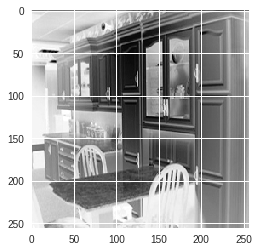

In [5]:
import random
r = random.randint(0,2986)        #隨機0~2985
plt.imshow(img_default[r][:,:,0]) #show出圖片，只顯示圖片的第一個通道

### 分割成訓練&測試資料集，(訓練:測試)=9:1

In [6]:
random_seed  = 2 #隨機分割
x_train, x_test, y_train, y_test = train_test_split(img_default, label_onehot, test_size = 0.1, random_state=random_seed)
x_train.shape, y_train.shape, x_test.shape, y_test.shape #(train_img, train_label, test_img, test_label)

((2686, 256, 256, 3), (2686, 15), (299, 256, 256, 3), (299, 15))

### Transfer learning(遷移學習)-Keras Xception預訓練模型
-參數
1. include_top：是否保留頂層的3個全連接網絡
2. weights：None代表隨機初始化，即不加載預訓練權重.'imagenet'代表加載預訓練權重
3. input_tensor：可填入Keras tensor作為模型的圖像輸出張量
4. input_shape：可選，僅在include_top=False時有效（否則輸入形狀必須為(299,299,3)），這時輸入的圖片應該要有三通道(rgb)，指明輸入圖片的shape，圖片的寬高必須大於71，如（150,150,3）
5. pooling：當include_top = False時，該參數指定了池化方式.None代表不池化，最後一個卷積層的輸出為4D張量.'avg'代表全局平均池化，'Max'代表全局最大值池化。
6. classes：可選，圖片分類的類別數，當僅include_top=True並且不加載預訓練權重時可用。

In [7]:
base_model = Xception(input_shape=(256, 256, 3), weights='imagenet', include_top=False) #載入預訓練模組，設定自訂圖片大小(預設為299*299)
x = base_model.output           #添加全域空間的平均池化層
x = GlobalAveragePooling2D()(x) #
predictions = Dense(15, activation='softmax')(x) #建立回歸模型，15種類別應用Softmax回歸模型
model = Model(base_model.input, predictions)     #架構結合
print(model.summary())                           #顯示模型結構

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

### 配置學習過程

In [8]:
model.compile(optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0) , loss = "categorical_crossentropy", metrics=["accuracy"])

### 針對訓練集進行數據增強

In [9]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,            # 布林值。將輸入數據的均值設置為0，逐特徵進行。
    samplewise_center=False,             # 布林值。將每個樣本的均值設置為0。
    featurewise_std_normalization=False, # 布林值。將輸入除以數據標準差，逐特徵進行。
    samplewise_std_normalization=False,  # 布林值。將每個輸入除以其標準差。
    zca_whitening=False,                 # 布林值。應用ZCA白化。
    rotation_range=20,                   # 整數。隨機旋轉的度數範圍。
    zoom_range = 0.1,                    # 浮點數或[lower，upper]。隨機縮放範圍。
    width_shift_range=0.25,              # 浮點數（總寬度的比例）。隨機水平移動的範圍。
    height_shift_range=0.25,             # 浮點數（總高度的比例）。隨機垂直移動的範圍。
    horizontal_flip=False,               # 布林值。隨機水平翻轉。
    vertical_flip=False)                 # 布林值。隨機垂直翻轉。

datagen.fit(x_train) # 計算特徵正規化所需的數量

### 開始訓練

In [11]:
epochs = 15 
batch_size = 32
history = model.fit_generator (datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)])

Epoch 1/15
 - 48s - loss: 1.2331 - acc: 0.6153 - val_loss: 4.0326 - val_acc: 0.5251
Epoch 2/15
 - 44s - loss: 0.6512 - acc: 0.7981 - val_loss: 3.5129 - val_acc: 0.6087
Epoch 3/15
 - 44s - loss: 0.5293 - acc: 0.8343 - val_loss: 1.4040 - val_acc: 0.7157
Epoch 4/15
 - 44s - loss: 0.4282 - acc: 0.8636 - val_loss: 1.4367 - val_acc: 0.7625
Epoch 5/15
 - 44s - loss: 0.3534 - acc: 0.8930 - val_loss: 2.9006 - val_acc: 0.6656
Epoch 6/15
 - 44s - loss: 0.3377 - acc: 0.8994 - val_loss: 1.1064 - val_acc: 0.8227
Epoch 7/15
 - 44s - loss: 0.3042 - acc: 0.9042 - val_loss: 2.0569 - val_acc: 0.7291
Epoch 8/15
 - 44s - loss: 0.3274 - acc: 0.9036 - val_loss: 1.4344 - val_acc: 0.7726
Epoch 9/15
 - 44s - loss: 0.2343 - acc: 0.9272 - val_loss: 2.2986 - val_acc: 0.7023
Epoch 10/15
 - 44s - loss: 0.2448 - acc: 0.9228 - val_loss: 1.0342 - val_acc: 0.8294
Epoch 11/15
 - 44s - loss: 0.2004 - acc: 0.9394 - val_loss: 2.6318 - val_acc: 0.6923
Epoch 12/15
 - 44s - loss: 0.1661 - acc: 0.9461 - val_loss: 2.1288 - val_a

### 儲存訓練模型

In [12]:
model.save("model.h5")

### 以測試集對模型做評分

In [13]:
scores=model.evaluate(x_test, y_test)    
print("Accuracy=", scores)  
print("Accuracy=", scores[1])  

299/299 [==============================] - 2s 6ms/step
Accuracy= [0.57012248123179499, 0.91973244147157196]
Accuracy= 0.919732441472


### 繪製模型準確度及Loss值之圖形

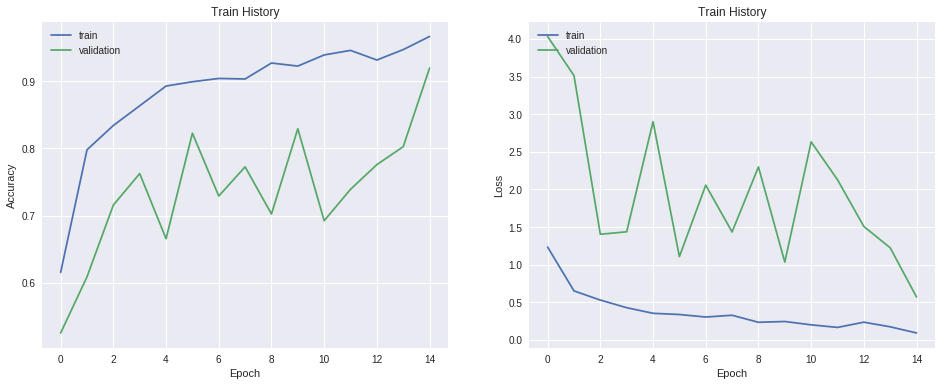

In [14]:
import matplotlib.pyplot as plt  
def show_train_history(history):
    fig=plt.gcf()
    fig.set_size_inches(16, 6)
    plt.subplot(121)
    plt.plot(history.history["acc"])
    plt.plot(history.history["val_acc"])
    plt.title("Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["train", "validation"], loc="upper left")
    plt.subplot(122)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Train History")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
show_train_history(history) 

### 匯入要進行預測的圖像

In [15]:
df = pd.read_csv(datapath + 'img-submission.csv') #submission檔內有每個圖片的檔名
len(df) #看看有幾筆
list_end=df.id.as_matrix().tolist()
test_img = np.zeros(shape=[1500,width,width,3])
count = 0
for i in list_end:
    img=cv2.imread(datapath + 'testset/'+ i +'.jpg')
    img=cv2.resize(img,(width,width)) 
    test_img[count] = img
    count += 1
    
test_img.shape

(1500, 256, 256, 3)

### 圖像正規化

In [16]:
test_img = test_img/255

### 隨機開一張圖來看

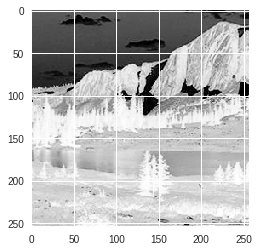

In [17]:
r1 = random.randint(0,1500)     #隨機0~1500
plt.imshow(test_img[r1][:,:,0]) #show出圖片，只顯示圖片的第一個通道

### 使用訓練好的模型進行預測

In [18]:
prediction=model.predict(test_img)
print(prediction)

[[  8.07236957e-16   6.95684106e-27   3.48056509e-18 ...,   1.00000000e+00
    2.46417714e-25   3.65988605e-30]
 [  6.01344807e-10   6.71744882e-10   5.86794933e-08 ...,   7.16458504e-10
    1.58857167e-13   3.99094948e-04]
 [  2.10495695e-01   1.41580222e-05   3.25021008e-03 ...,   6.52054012e-01
    1.94876775e-05   5.96522204e-06]
 ..., 
 [  3.17502952e-07   9.71917546e-11   4.19572155e-09 ...,   1.35582754e-08
    6.46677067e-09   3.34922574e-13]
 [  9.93996263e-01   1.57238855e-16   1.91316811e-13 ...,   4.00682438e-06
    5.66633940e-17   1.46921326e-19]
 [  5.17493456e-16   1.35322363e-12   5.73302561e-09 ...,   1.31281208e-10
    9.99969829e-11   2.03035713e-11]]


### 將預測結果轉回One Hot Encoding前的樣子

In [19]:
prediction = np.argmax(prediction,axis = 1)

### 將結果輸出成csv檔

In [20]:
pred_df = pd.DataFrame(prediction, index=df["id"], columns=["class"])
pred_df.to_csv('Xception_result.csv', header=True, index_label='id')

### 檢查csv檔

In [21]:
df0 = pd.read_csv('Xception_result.csv')
df0.head(12)

,id,class
0,c117693e1cf24a5232090d1548cb11d4e5ea0df65680c4a56a8e8aa2beede330,12
1,96baacc2e97886a998807ce197574821a6dc83c227c7469961c01ab315908371,10
2,f9bd26db23eb9b544ca78be79b11b4d1259e802885861d8b66a8e709995229db,12
3,b42bcd8e6645fcc2ac40ee44b7dc8d74a77081d0aea7a1a88eaba3d8393001c3,5
4,5bc53cef9168882f0ff67a81b3e7269f62b7fd5343d06dafe63570d5032c21f3,2
5,f80823d6bff6c0beba6d55a3157d7a4fa2de4f966351e0fa7d322e5962f46ece,7
6,3a12151639cf9f8e2af9ea36c2ce6bb15dd8730ea6dc904621dd754ebd3c1155,1
7,a5e0980425df5b98864a9580e081a7209e1b6810ed515afab1617cdc62299ac1,10
8,d4ea833073c4391387bebaef3c51c22861c1ff108cbb3c52f33c0dc3c81564f0,11
9,013c78d920be5390dbc66ca238ae3f49a2b0cf13e3601331678b871fc0d4a237,8


![result](Xceptionresult.PNG)